# Anomaly Detection in Credit Card Transactions

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split, KFold,GridSearchCV, cross_val_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,recall_score,r2_score,precision_score
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8

data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

## Exploratory Data Analysis


In [7]:
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

C:\Users\vinee\AppData\Local\Temp\ipykernel_18496\4059931755.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts_value  = pd.value_counts(data['Class'], sort= True)


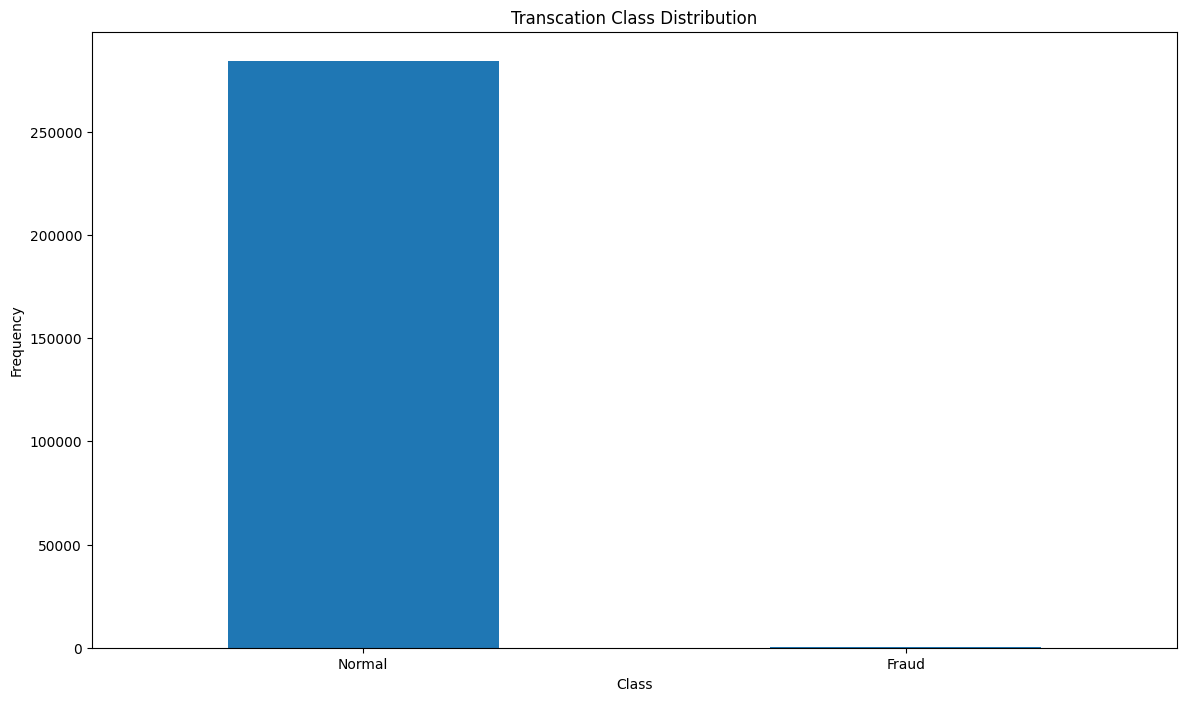

In [8]:
counts_value  = pd.value_counts(data['Class'], sort= True)
counts_value

counts_value.plot(kind= 'bar',rot =0)
plt.title('Transcation Class Distribution')
plt.xticks(range(2),['Normal','Fraud'])
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [9]:
Fraud = data[data['Class'] == 1]
Valid = data[data['Class']==0]
print(data.shape)
print(Fraud.shape)
print(Valid.shape)
Fraud_percentage = len(Fraud)/len(data)
print(Fraud_percentage)

(284807, 31)
(492, 31)
(284315, 31)
0.001727485630620034


Here, the Fraud transactions are only 492 compared to valid transaction,which are 284315, out of the total 284807 transactions made. This shows  that the data is heavy imbalanced as only 0.001727 transactions are fraud. 

In [10]:
Valid.Amount.describe()


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [11]:
Fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

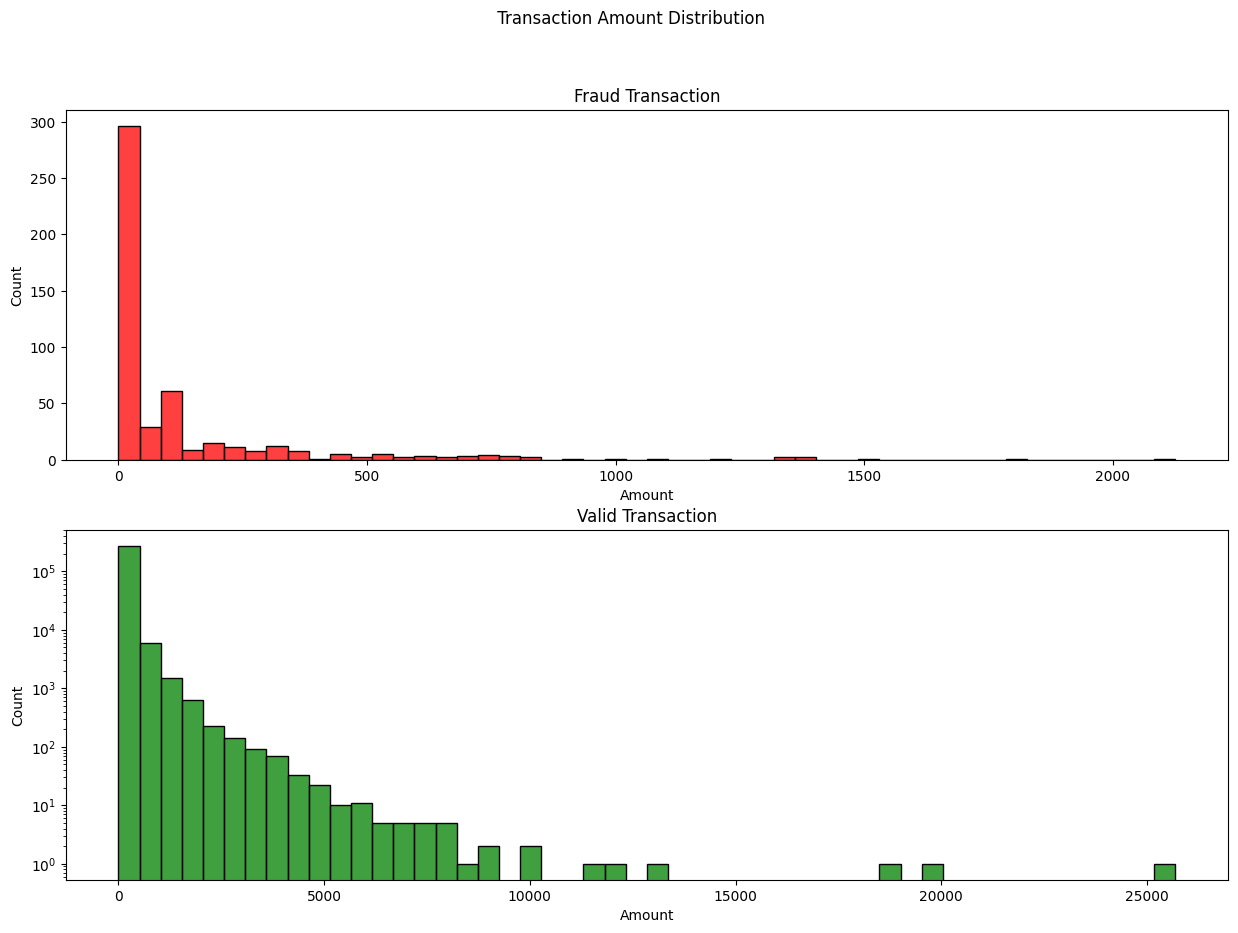

In [12]:
fig,(row1,row2) = plt.subplots( 2, 1, figsize=(15,10))
fig.suptitle(' Transaction Amount Distribution')
sns.histplot(Fraud.Amount,bins=50,color='red',ax=row1)
row1.set_title('Fraud Transaction')
row1.set_xlabel('Amount')
sns.histplot(Valid.Amount,bins=50,color='green',ax=row2)
row2.set_title('Valid Transaction')
row2.set_xlabel('Amount')
plt.yscale('log')
# plt.xlim((0,20000))
plt.show()

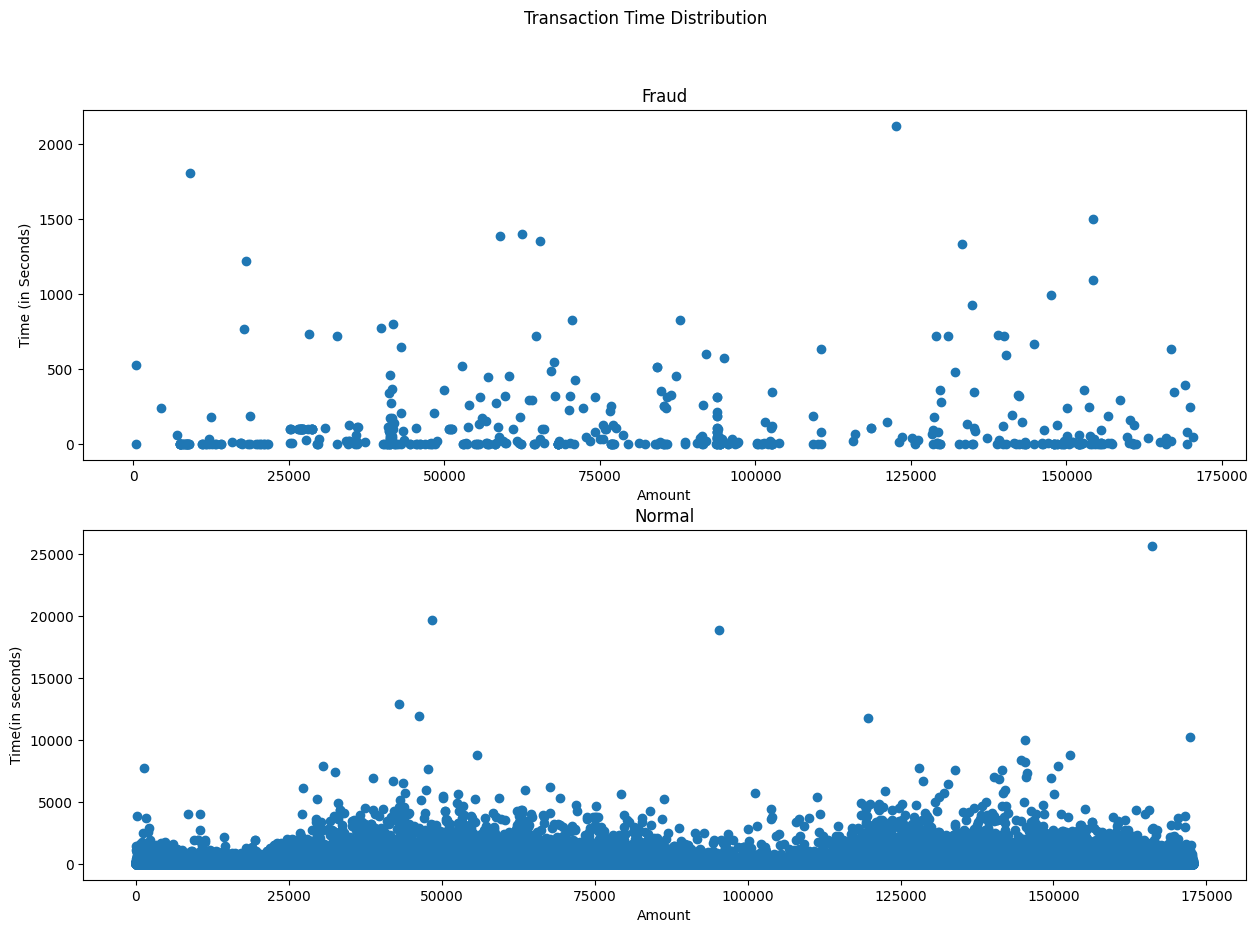

In [13]:
fig, (row1,row2) = plt.subplots( 2, 1, figsize=(15,10))
fig.suptitle('Transaction Time Distribution')
row1.scatter(Fraud.Time,Fraud.Amount)
row1.set_title('Fraud')
row1.set_xlabel('Amount')
row1.set_ylabel('Time (in Seconds)')
row2.scatter(Valid.Time,Valid.Amount)
row2.set_title('Normal')
row2.set_xlabel('Amount')
row2.set_ylabel('Time(in seconds)')
plt.show()

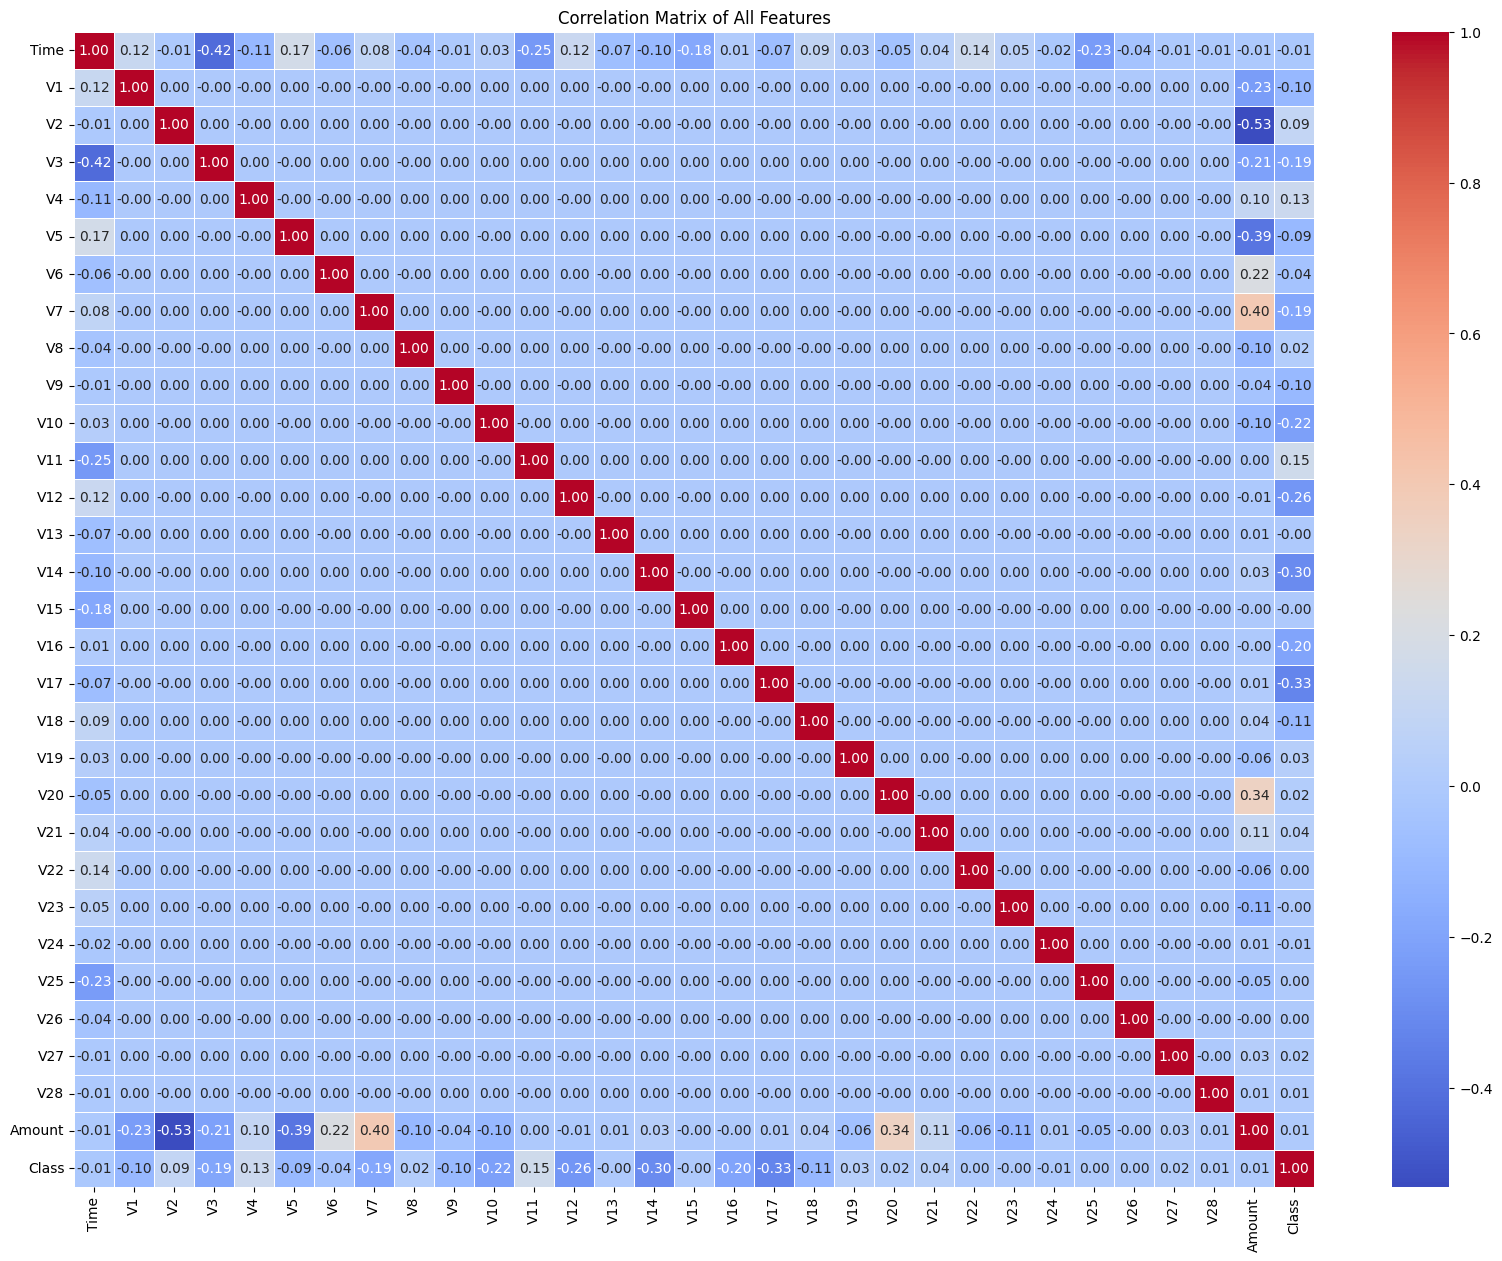

In [14]:
corr_matrix = data.corr()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix,cmap="coolwarm",fmt="0.2f",annot=True,cbar=True,linewidths=0.5)
plt.title('Correlation Matrix of All Features')
plt.show()

In [15]:
correlation_with_class = corr_matrix['Class'].sort_values(key=abs,ascending=False)
print("Top features in correlation matrix are:\n")
correlation_with_class.head(10)

Top features in correlation matrix are:



Class    1.000000
V17     -0.326481
V14     -0.302544
V12     -0.260593
V10     -0.216883
V16     -0.196539
V3      -0.192961
V7      -0.187257
V11      0.154876
V4       0.133447
Name: Class, dtype: float64

## MODAL PREDICTION

In [16]:
cc_data = data.copy()

cc_data1 = cc_data.sample(frac=0.1,random_state=1)
cc_data1
print(cc_data1.shape)

(28481, 31)


In [17]:
fraud = cc_data1[cc_data1['Class']== 1]
normal = cc_data1[cc_data1['Class']==0]
print("Fraction of Fraud data :", len(fraud)/len(normal))
print("Fraud Cases :", len(fraud))
print("Normal Cases :", len(normal))

Fraction of Fraud data : 0.0017234102419808666
Fraud Cases : 49
Normal Cases : 28432


In [18]:
state = np.random.RandomState(42)
X = cc_data1.drop('Class', axis =1)
y= cc_data1['Class']
X_outliers = state.uniform(low =0,high =1, size = (X.shape[0],X.shape[1]))
print(X.shape)
print(y.shape)

(28481, 30)
(28481,)


### Isolation Forest and Local Outlier Factor(LOF) Algorithm


Isolation Forest Results:
Number of errors: 73
Accuracy Score: 0.9974368877497279
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481


Local Outlier Factor Results:
Number of errors: 97
Accuracy Score: 0.9965942207085425
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481



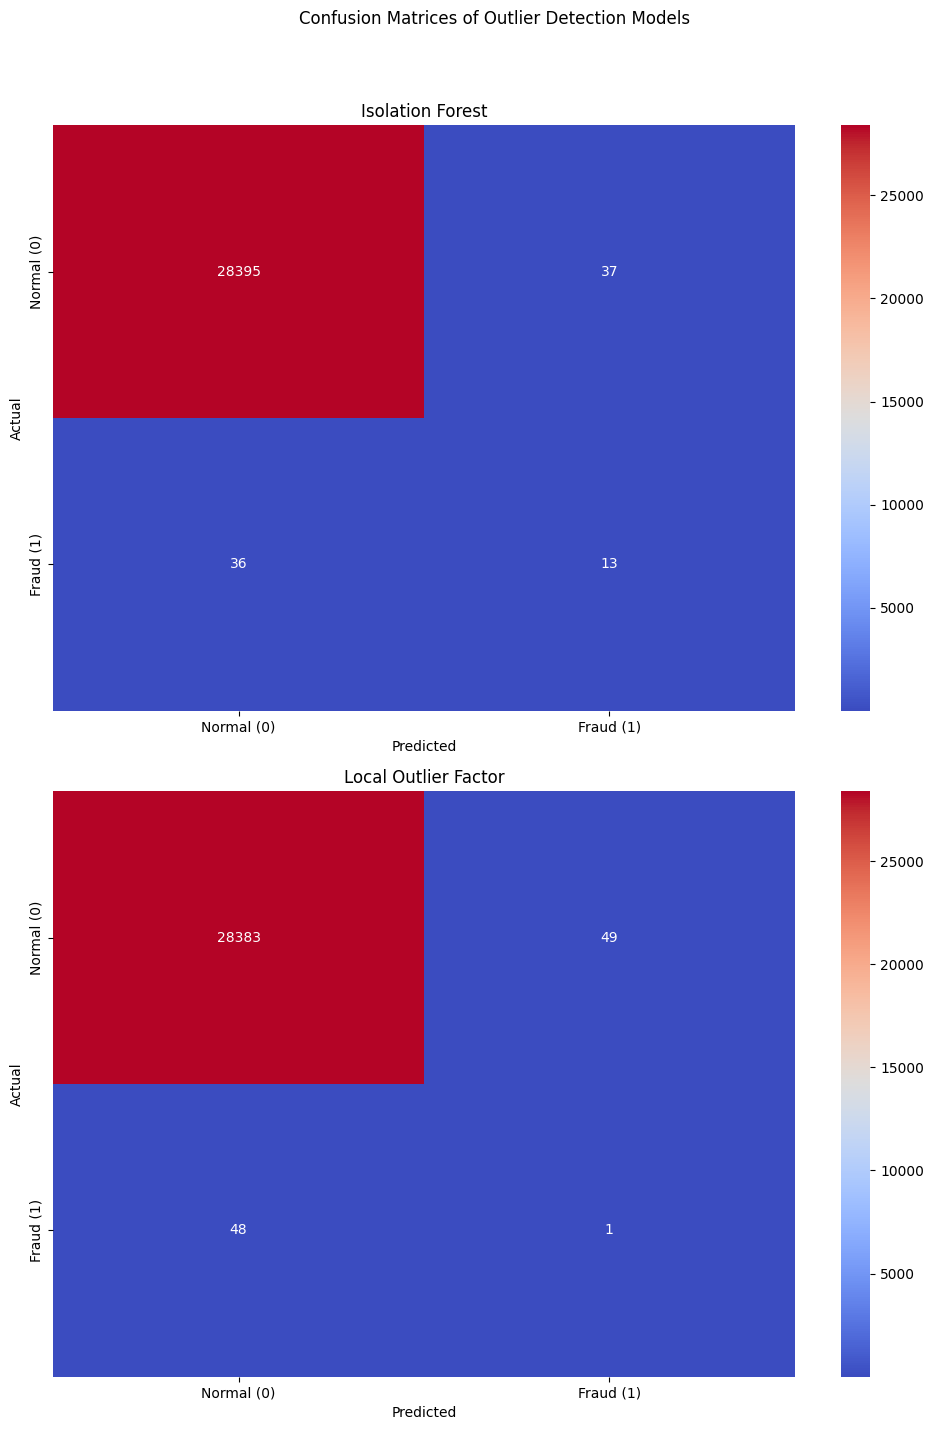

In [51]:
outlier_fraction = len(fraud)/len(normal)

Classifier = {
    "Isolation Forest" : IsolationForest(n_estimators=100,max_samples= len(X),random_state=42,contamination=outlier_fraction),
    "Local Outlier Factor" : LocalOutlierFactor(n_neighbors=20,contamination=outlier_fraction)
}

fig , axes = plt.subplots( 2, 1, figsize=(10,15))
fig.suptitle("Confusion Matrices of Outlier Detection Models")

for ax, (clf_name, clf) in zip(axes, Classifier.items()):
    if clf_name == "Local Outlier Factor":
        y_pred  = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)

    y_pred =[1 if i ==-1 else 0 for i in y_pred]

    print(f"\n{clf_name} Results:")
    print(f"Number of errors: {(y_pred != y).sum()}")
    print("Accuracy Score:", accuracy_score(y, y_pred))
    print("Classification Report:")
    print(classification_report(y, y_pred))

    cm = confusion_matrix(y, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap="coolwarm", cbar=True, ax=ax)
    ax.set_title(clf_name)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Normal (0)', 'Fraud (1)'])
    ax.set_yticklabels(['Normal (0)', 'Fraud (1)'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




### XGBoost Classifier

In [39]:
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

X = cc_data1.drop('Class',axis =1)
y = cc_data1['Class']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.3,random_state=42)

sm = SMOTE(random_state =42)
X_train_res,y_train_res = sm.fit_resample(X_train,y_train)

model = XGBClassifier(n_estimators = 100, max_depth = 5, learning_rate =0.1,subsample=0.8, colsample_bytree=0.8, random_state=42)

model.fit(X_train_res,y_train_res)
y_pred_xg = model.predict(X_test)
print(f"Number of errors (XGBoost): {(y_pred_xg != y_test).sum()}")
print("\n Acccuracy Score for XGBoost Classifier : ", accuracy_score(y_test,y_pred_xg))
print("\n Classification report for XGBoost Classifier : ", classification_report(y_test,y_pred_xg))

Number of errors (XGBoost): 15

 Acccuracy Score for XGBoost Classifier :  0.999247630034609

 Classification report for XGBoost Classifier :                precision    recall  f1-score   support

           0       1.00      1.00      1.00     19906
           1       0.79      0.71      0.75        31

    accuracy                           1.00     19937
   macro avg       0.89      0.85      0.87     19937
weighted avg       1.00      1.00      1.00     19937



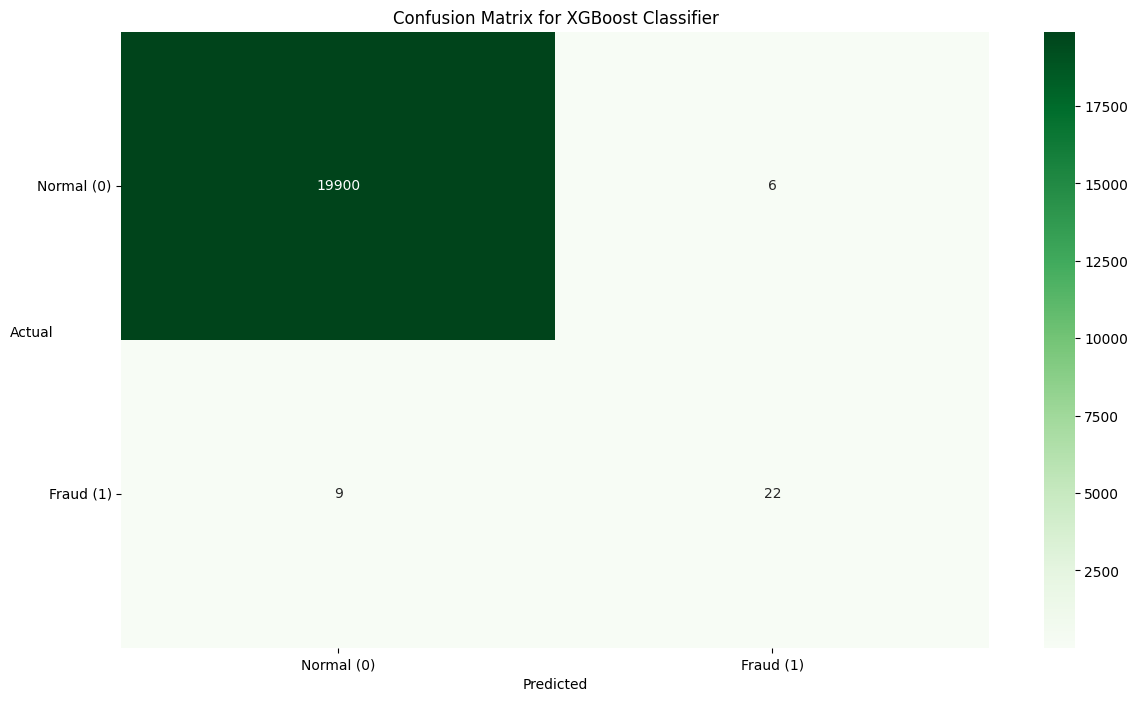

In [38]:
cm_xg = confusion_matrix(y_test,y_pred_xg)
sns.heatmap(cm_xg,annot=True,fmt='d',cmap='Greens')
plt.title('Confusion Matrix for XGBoost Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual',rotation = 0)
plt.xticks([0.5,1.5],['Normal (0)', 'Fraud (1)'])
plt.yticks([0.5,1.5],['Normal (0)', 'Fraud (1)'],rotation =0)
plt.show()

### Autoencoder

In [54]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

X_train_au,X_test_au,y_train_au,y_test_au = train_test_split(X_scaled,y,train_size=0.3,random_state=42,stratify=y)

X_train_au = X_train_au[y_train ==0] # Training only on-fraud data

input_dim = X_train.shape[1]
encoding_dim =14

input_layer = Input(shape = (input_dim,))
encoder = Dense(encoding_dim,activation ="relu")(input_layer)
encoder = Dense(7,activation="relu")(encoder)
decoder = Dense(encoding_dim,activation="relu")(encoder)
decoder = Dense(input_dim,activation ='linear')(decoder)

autoencoder = Model(inputs= input_layer, outputs = decoder)

autoencoder.compile(optimizer='adam',loss='mse')

history = autoencoder.fit(X_train_au,X_train_au,epochs =20, batch_size=32,validation_split=0.1,verbose=0)

X_test_pred = autoencoder.predict(X_test_au)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

threshold = np.percentile(mse, 95) 
y_pred_au = [1 if e > threshold else 0 for e in mse]

print(f"Number of errors (Autoencoder): {(np.array(y_pred_au) != np.array(y_test_au)).sum()}")
print("\nAccuracy:", accuracy_score(y_test_au, y_pred_au))
print("\nClassification Report:\n", classification_report(y_test_au, y_pred_au))

624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Number of errors (Autoencoder): 1029

Accuracy: 0.9483874203741787

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97     19903
           1       0.00      0.03      0.00        34

    accuracy                           0.95     19937
   macro avg       0.50      0.49      0.49     19937
weighted avg       1.00      0.95      0.97     19937



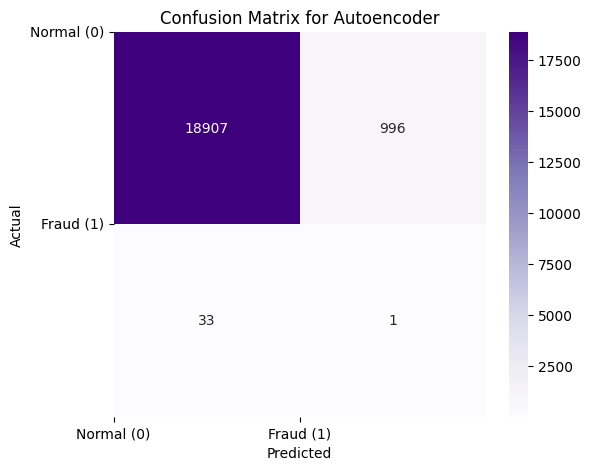

In [60]:

y_pred_au = np.array(y_pred_au)
cm_auto = confusion_matrix(y_test_au, y_pred_au)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_auto, annot=True, fmt='d', cmap='Purples', cbar=True)
plt.title('Confusion Matrix for Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0, 1], ['Normal (0)', 'Fraud (1)'])
plt.yticks([0, 1], ['Normal (0)', 'Fraud (1)'], rotation=0)
plt.show()

# print(y_test_au.shape)
# print(y_pred_au.shape)

## OBSERVATIONS

- XGBoost achieved the highest accuracy, with only 15 errors out of 19,937 records and an accuracy of 99.92%. It also had a recall of 71% and F1-score of 75%, making it the best overall performer for fraud detection.

- Autoencoder detected 1029 errors and had a recall of only 3% for fraud detection, despite an overall accuracy of 94.84%. This shows it struggled with detecting fraud but was very accurate for normal transactions.

- Isolation Forest performed fairly well, with 73 errors on the test set and an accuracy of 99.74%. It achieved a fraud recall of 27%, which is significantly better than LOF and Autoencoder, though not as good as XGBoost.

- Local Outlier Factor (LOF) had 97 errors and an accuracy of 99.66%, but its fraud recall was just 2%, indicating it barely detected fraudulent cases, even though it performed well on normal ones.

## CONCLUSION : 
- XGBoost is clearly the most effective model for fraud detection in this highly imbalanced dataset, achieving high recall and precision.

- Autoencoder, while powerful in some anomaly detection tasks, struggled here likely because of the high class imbalance and lack of enough fraudulent patterns in the training set.

- Isolation Forest offers a solid balance between performance and speed for unsupervised detection, making it a good choice when label information is not available.

- LOF showed very limited ability to detect fraud and should be avoided or tuned heavily if used.